# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames, check_shutter_open, 
    get_each_frame_intensity, get_avg_img, load_data, load_mask,get_fields, reverse_updown, 
    apply_mask, show_img,check_ROI_intensity,run_time, cal_g2)


 
from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2)





from chxanalys.Two_Time_Correlation_Function import Get_Pixel_Array, auto_two_Array,show_C12, get_one_time_from_two_time



%matplotlib notebook

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Make a directory for saving results

In [2]:
CYCLE = '2016_2'

username = getpass.getuser()

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [61]:
uid='ee6975a1-9161'   #1% wt PEG

# Don't Change these lines below here

In [25]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger_4M_cam_img_image_lightfield
scan_id, full-uid, data path are:  1224--ee6975a1-9161-4315-9929-4db995a91b5c--/XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138


In [113]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5


In [27]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [28]:
md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [96]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000      # detector to sample distance (mm)

exposuretime= md['count_time']
acquisition_period = md['frame_time']


center = [ 846,1830]  # center of the speckle pattern


center=[center[1], center[0]]
print (center)



[1830, 846]


In [97]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [98]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1830, 846],
 'dpix': 0.075000003562308848,
 'lambda_': 1.3776,
 'timeperframe': 1.00001,
 'uid': 'ee6975a1-9161'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [75]:
mask_path = '/home/yuzhang/Analysis/2016_1/Results/'
mask_name = 'ee6975a1-9161_mask.npy'

<IPython.core.display.Javascript object>


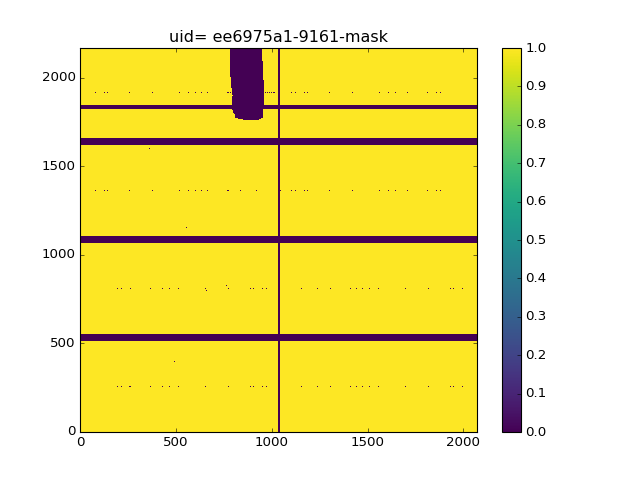

In [76]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid= %s-mask'%uid )

In [78]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


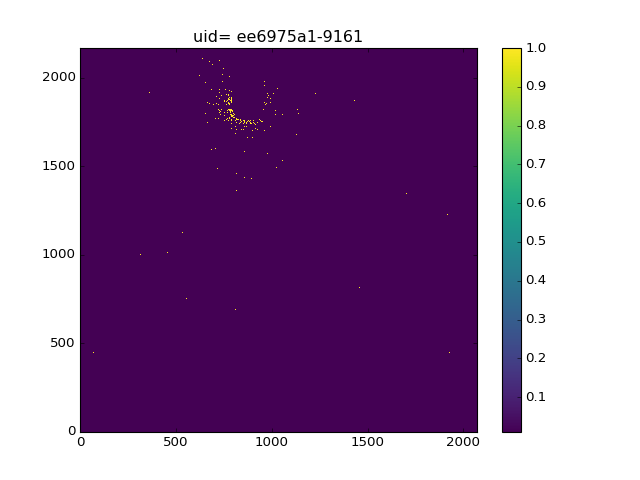

In [79]:
show_img( imgsa[0],  vmin=0.01, vmax=1, logs=False, image_name= 'uid= %s'%uid) 

## Clean Data
* Check shutter open frame to get good time series
* Find bad frames by checking total scattering intensity 


In [86]:
good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )

The first frame with open shutter is : 0


In [87]:
good_series = apply_mask( imgsa[good_start:], maskr )

<IPython.core.display.Javascript object>


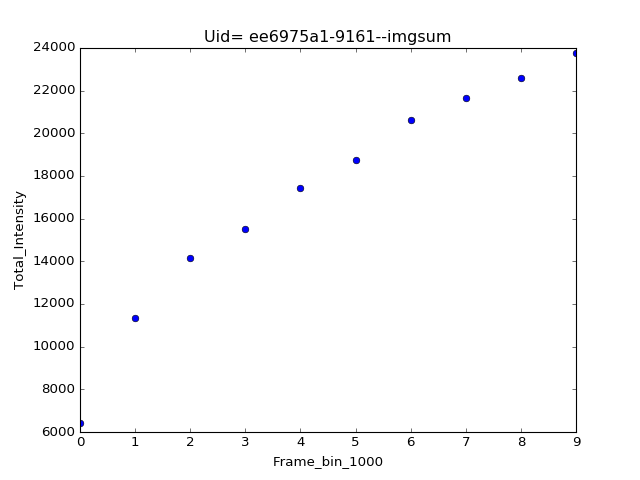

No bad frames are involved.


In [88]:
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1000, 
                                bad_pixel_threshold=1e14,  plot_ = True, uid=uid)

## Get intensity average image

<IPython.core.display.Javascript object>


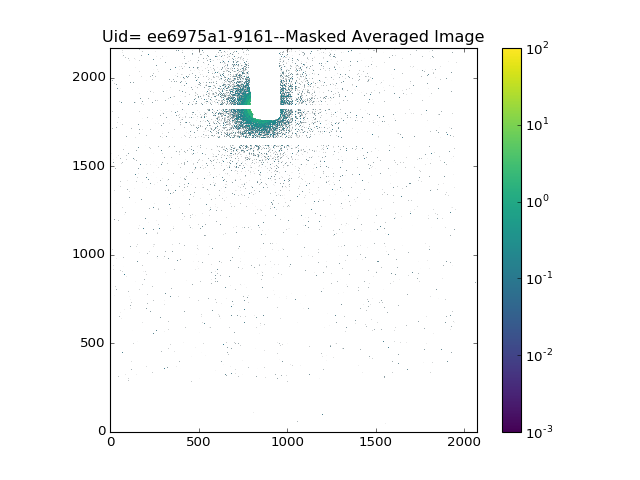

In [89]:
avg_img =  get_avg_img( good_series, sampling = 1000, plot_ = True, uid =uid)

## Get circular average 
* Do plot and save q~iq


In [90]:
hmask = create_hot_pixel_mask( avg_img, 1e8)

<IPython.core.display.Javascript object>


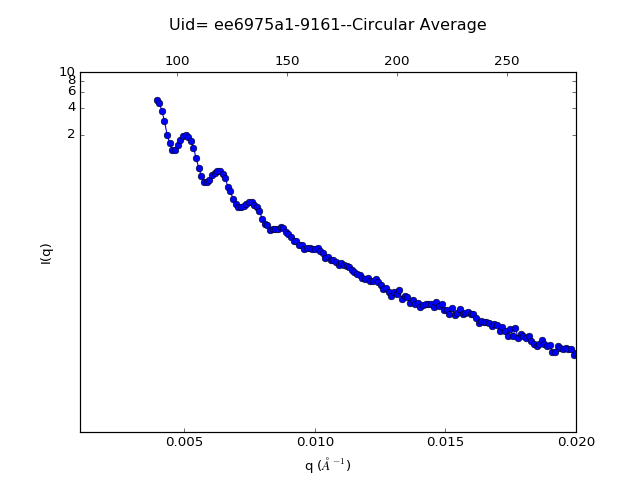

In [101]:
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                    plot_ = True, plot_qinpixel=False, xlim=[0.001,.02], ylim = [0.001, 10])

In [105]:
save_lists( [q,iq], ['q','iq'], filename= 'I(q)-uid=%s'%uid, path=data_dir)

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings

In [106]:
inner_radius= 58
outer_radius = 120
width = 2
num_rings = 6


In [107]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, pargs=setup_pargs   )

<IPython.core.display.Javascript object>


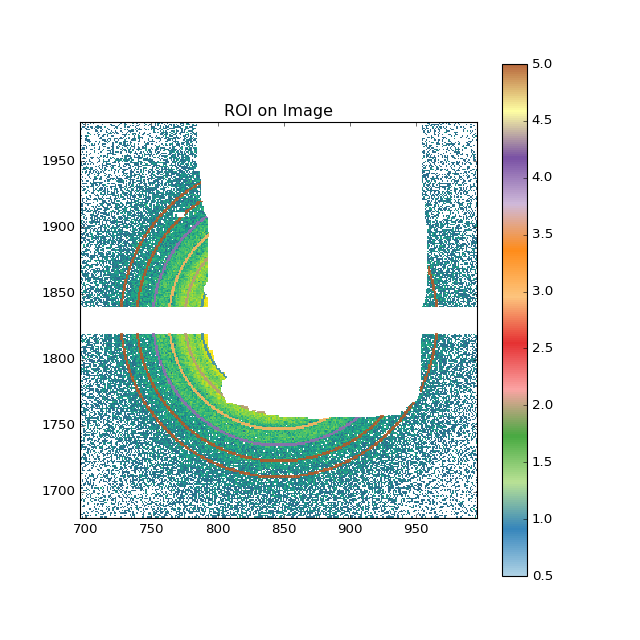

In [109]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=150, alpha=.9)

<IPython.core.display.Javascript object>


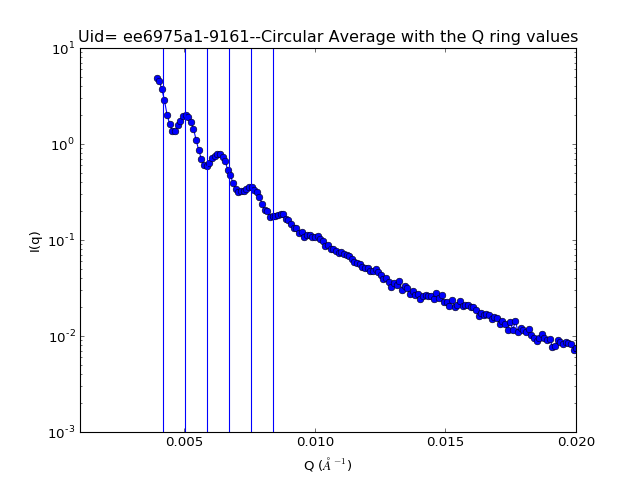

In [110]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.02], ylim = [0.001, 10])

## Check one ring intensity

<IPython.core.display.Javascript object>


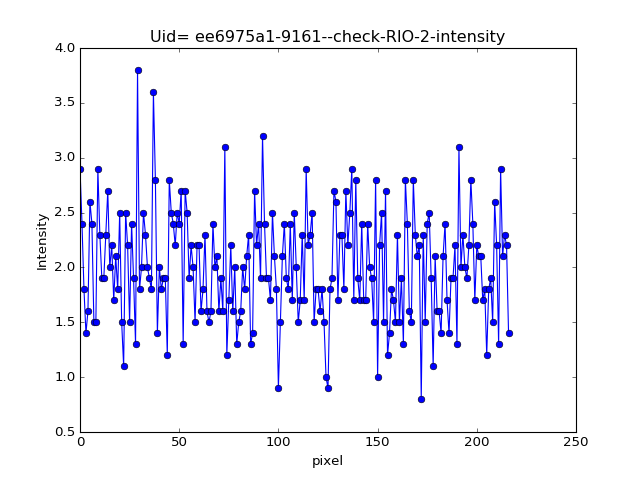

In [111]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 2, uid =uid )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [114]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width=10, edges = None )

<IPython.core.display.Javascript object>


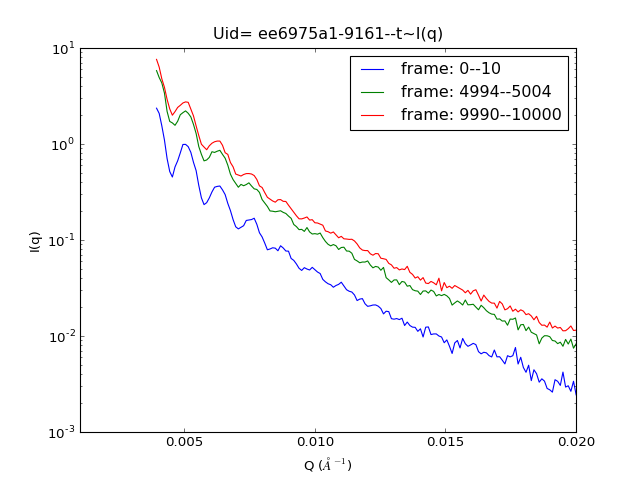

In [115]:
qp, iqs, q = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,  xlim=[0.001,0.02], ylim = [0.001, 10])

<IPython.core.display.Javascript object>


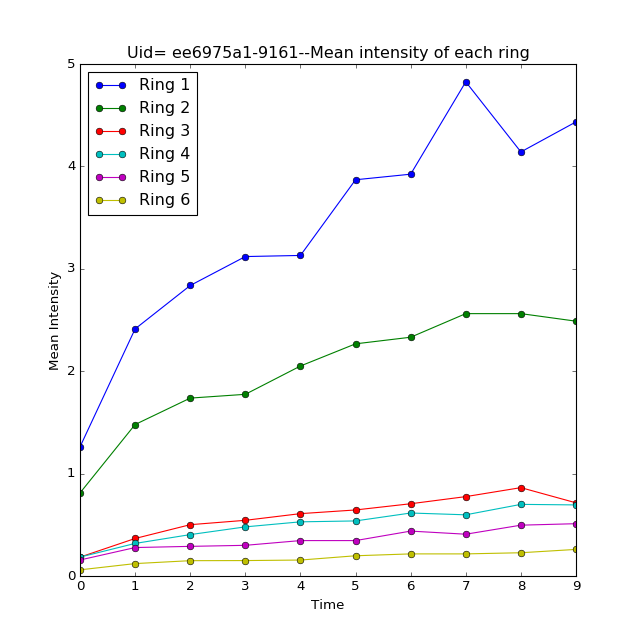

In [118]:
mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = 1000,
                                timeperframe = md['frame_time'], plot_ = True, uid = uid  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [119]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

False

### if define another good_series

In [120]:
if True:
    good_start = 10
    good_end = 200 #len( imgs )
    good_series = apply_mask( imgsr[good_start:good_end-1], maskr )

In [122]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--6--
189 frames will be processed...
G2 calculation DONE!
Total time: 0.14 min


In [125]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [126]:
save_saxs_g2(   g2, res_pargs )

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/ with filename as g2-uid=ee6975a1-9161-20160616-1737-.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


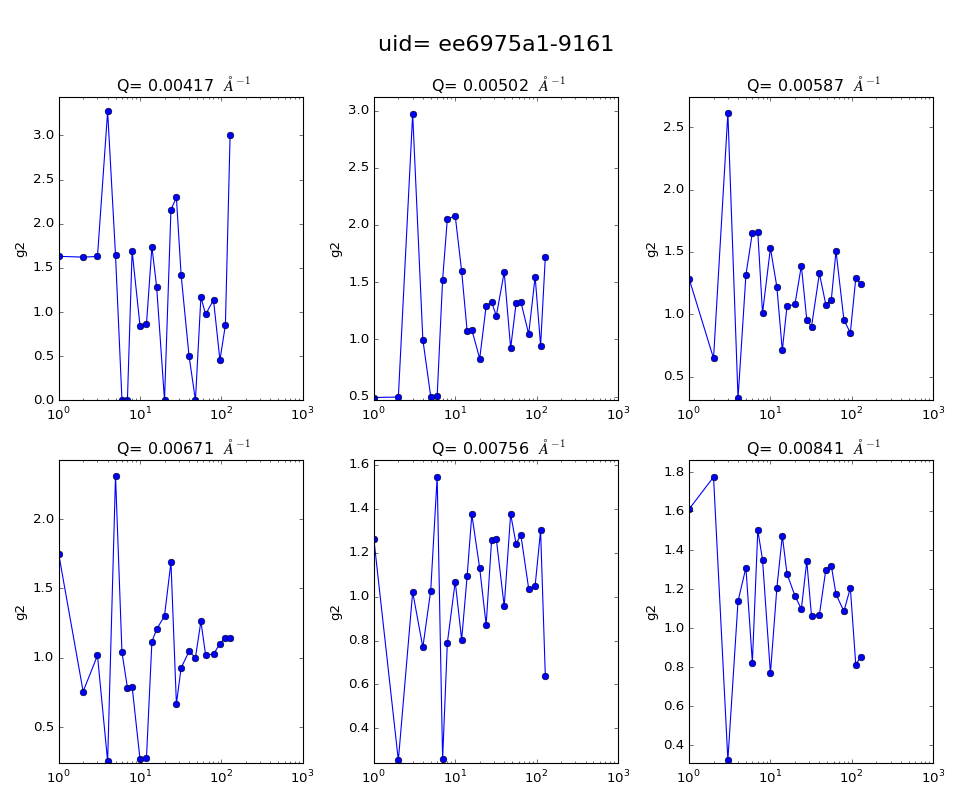

In [128]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs)              
#plot_gisaxs_g2( g2, taus,  vlim=[0.95, 1.05],qz_center=qz_center, qr_center=qr_center,uid = uid, path=path )

# Fit g2

In [130]:
fit= True

<IPython.core.display.Javascript object>


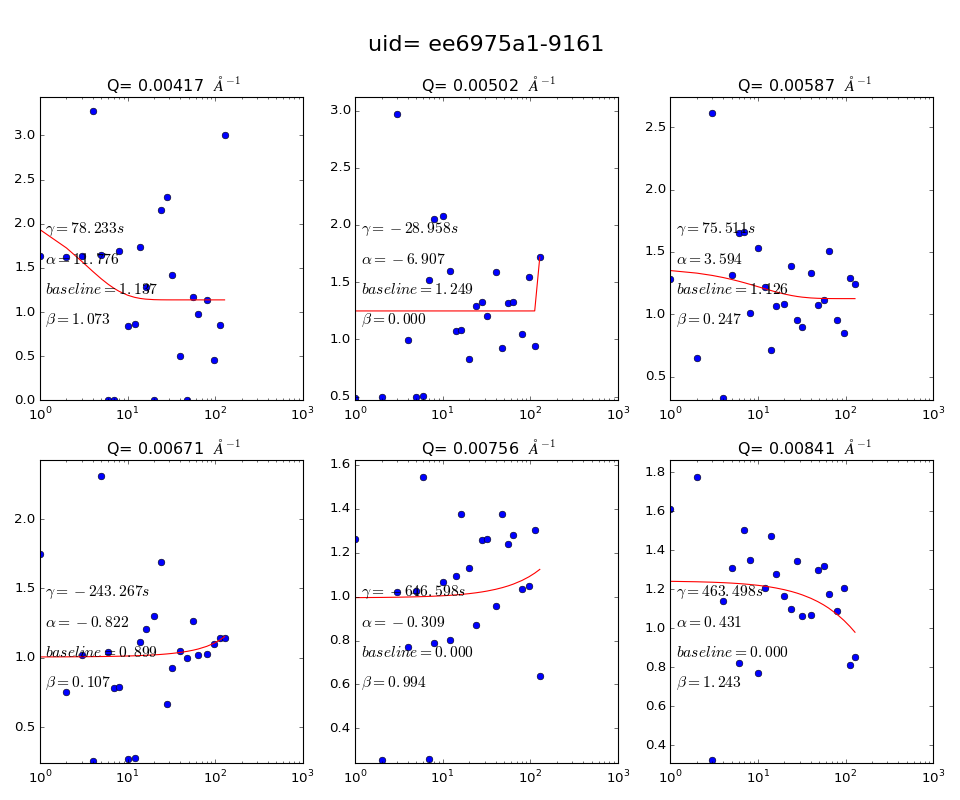

In [132]:
if fit:
    #result = fit_gisaxs_g2( g2, res_pargs, function = 'simple',  vlim=[0.95, 1.05],)
    result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05],)

The fitted diffusion coefficient D0 is:  9.32E+01   A^2S-1


<IPython.core.display.Javascript object>


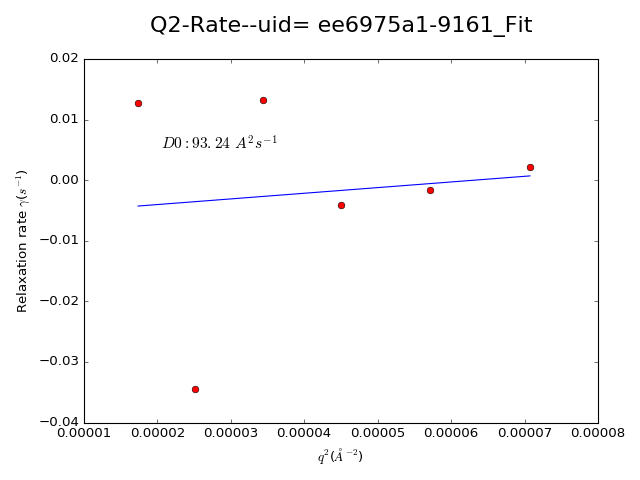

array([  9.32363563e+01,  -5.88582618e-03])

In [134]:
fit_q2_rate(  q_ring_center**2, result['rate'], uid=uid, path= data_dir )

In [62]:
#result

# For two-time

In [135]:
from chxanalys.XPCS_SAXS import (create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate)
from chxanalys.chx_generic_functions import (save_lists, create_time_slice)

In [136]:
run_two_time = True #False

In [139]:
if run_two_time:    
    qind, pixelist = roi.extract_label_indices(  ring_mask  )
    #good_start = 10
    #good_end = 300 #len( imgs )
    #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    run_time(t0)
    g12b = auto_two_Array( good_series, ring_mask, data_pixel = data_pixel ) 

Total time: 0.14 min
Total time: 0.00 min


<IPython.core.display.Javascript object>


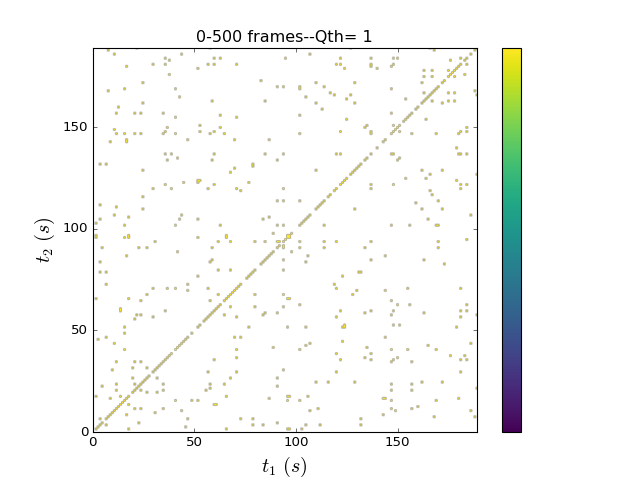

In [142]:
if run_two_time:
    show_C12(g12b, q_ind=1, N1=0, N2=500, vmin=1.006, vmax=1.19,  )

In [145]:
#g12b.shape

In [146]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)
    save_saxs_g2(   g2b,  res_pargs, taus=np.arange( g2b.shape[0]) *timeperframe, filename='g2_from_two-time')

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/ with filename as g2_from_two-time-uid=ee6975a1-9161-20160616-1742-.csv


/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  war

In [151]:
taus2 = np.arange( g2b.shape[0]) *timeperframe
res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

<IPython.core.display.Javascript object>


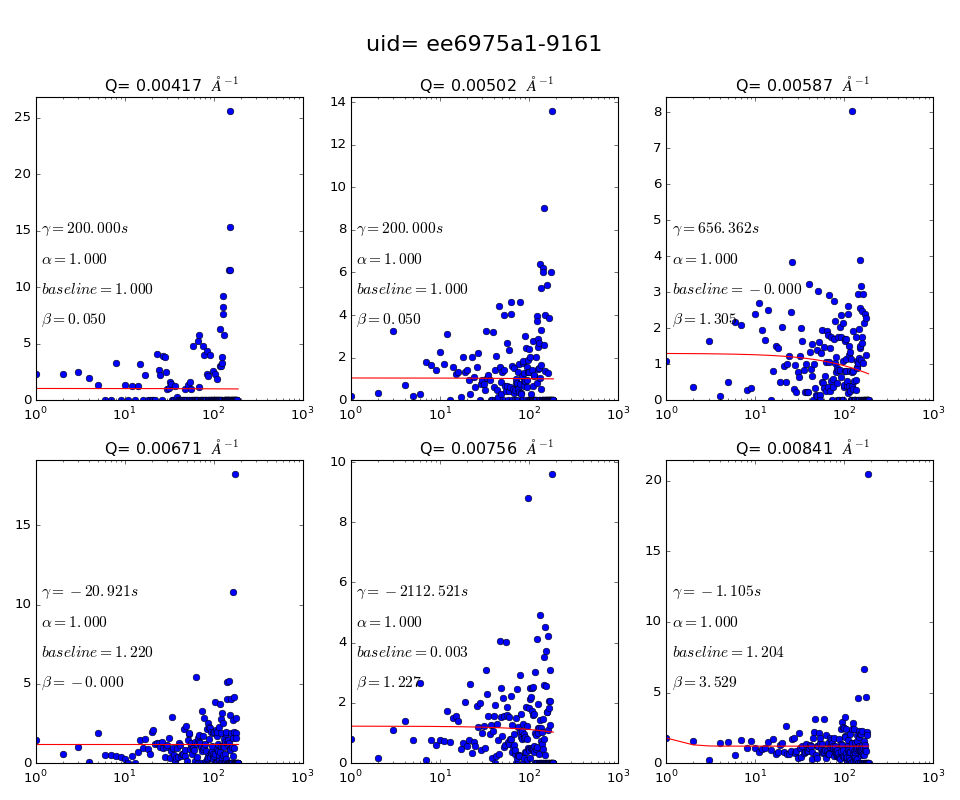

In [152]:
result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])

The fitted diffusion coefficient D0 is:  -1.33E+04   A^2S-1


<IPython.core.display.Javascript object>


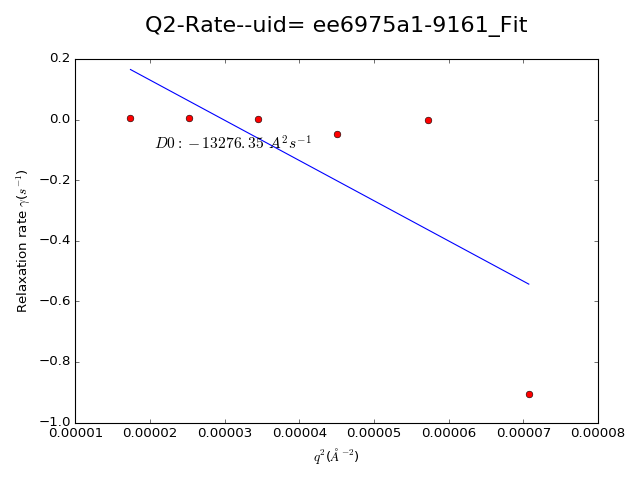

array([ -1.32763485e+04,   3.96131605e-01])

In [154]:
fit_q2_rate(  q_ring_center**2, result2['rate'], uid=uid, path= data_dir )

In [156]:
save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)

<IPython.core.display.Javascript object>


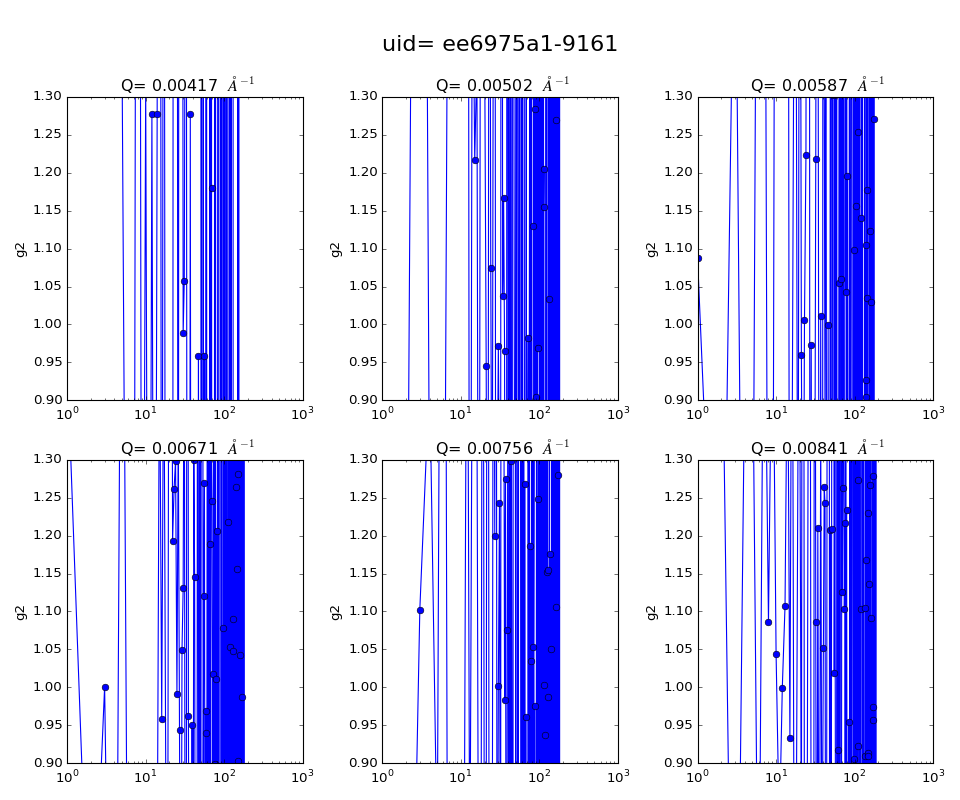

In [149]:
if run_two_time:
    plot_saxs_g2( g2b, taus= np.arange( g2b.shape[0]) *timeperframe, ylim=[0.9, 1.3],
             q_ring_center = q_ring_center, vlim=[.99, 1.01], uid = uid, path= data_dir )

# The End!